## Import library

In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import copy as cp
import calendar

In [2]:
# 載入所需函示庫
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels
import statsmodels.stats.libqsturng
from matplotlib import pyplot as plt
%matplotlib inline
# 設定圖形大小; DPI越大圖越大
plt.rcParams["figure.dpi"] = 100

In [3]:
def strtoint(s):
   #print(s)
    if type(s) != str :
        return s
    ss = s.split(',')
    #print(ss[0])
    temp = 0
    for i in range(len(ss)):
        temp = temp * 1000 + int(ss[i])
#     temp = float(temp / 1000000)
    return temp

## Build a library

In [4]:
transportCnt = dict()

In [5]:
year = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
month = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [6]:
for i in year:
    for j in month:
        if i == '2022' and j == '04':
            break
        dt_name = '+OÑ_¦¦¦BÑ¦¿t¦+«+¦B¦q¦+¡p_' + i + j+'.csv'
        df = pd.read_csv(dt_name,encoding='big5')
        for k in range(df.shape[0]):
            tmp = df['營運日'][k]
            if(tmp != tmp):
                continue
            tmp = df['營運日'][k].split('/')
            date = datetime(int(tmp[0]) + 1911, int(tmp[1]), int(tmp[2]))
            transport = strtoint(df['總運量'][k])
            transportCnt.setdefault(date,transport)

## Functions

In [7]:
def getHoliday(year, Holiday, df):
    name = []
    y = year
    i = year - 2005
    if(type(df[Holiday][i]) == datetime):
        name.append(df[Holiday][i])
    else:
        start, end = df[Holiday][i].split('-')
        start = start.split('/')
        start = [int(s) for s in start]
        end = end.split('/')
        end = [int(s) for s in end]

        if(start[0] == end[0]):
            name += [datetime(y, start[0], x) for x in np.arange(start[1], end[1] + 1, 1)]
        else:
            lastday = calendar.monthrange(y, start[0])[1]
            if(start[0] == 12):
                name += [datetime(y - 1, start[0], x) for x in np.arange(start[1], lastday + 1, 1)]
                name += [datetime(y, end[0], x) for x in np.arange(1, end[1] + 1, 1)]
            else:
                name += [datetime(y, start[0], x) for x in np.arange(start[1], lastday + 1, 1)]
    return name

In [8]:
def getHolidayLength(date):
    holiday, column, i = isHoliday([date.year], h_columns, date)
    if(holiday):
        return df[column][i]
    elif(date.isoweekday() == 6 or date.isoweekday() == 7):
        return 2
    else:
        return 0

In [9]:
def isHoliday(years, columns, date):
    for column in columns:
        for year in years:
            if(date in holiday_rec[column][year - 2005]):
                return True, column, year - 2005
    return False, -1, -1

In [10]:
def holiday_type(date):
    y = date.year
    m = date.month
    d = date.day
    traditional = ['春節', '端午', '中秋']
    national = ['雙十', '二二八', '元旦', '清明', '勞動']
    years = np.arange(2015, 2023, 1)
    if(isHoliday(years, traditional, date)[0]):
        return 'Traditional'
    elif(isHoliday(years, national, date)[0]):
        return 'National'
    elif((m == 12 and d == 25) or (m == 2 and d == 14) or (m == 10 and d == 31)):
        return 'Western'
    elif((m == 8 and d == 8) or (m == 5 and d <= 14 and d >= 8 and date.isoweekday() == 7)):
        return 'Fother'
    elif(date.isoweekday() == 6 or date.isoweekday() == 7):
        return 'Weekend'
    else:
        return 'Weekday'

In [11]:
def season(date):
    s = []
    start = 3
    for i in range( 4 ) : 
        s.append( [])
        for j in range( 3 ) :
            s[i].append( start ) 
            start = ( start % 12 ) + 1
    m = date.month
    if(m in s[0]):
        return 'Spring'
    elif(m in s[1]):
        return 'Summer'
    elif(m in s[2]):
        return 'Fall'
    else:
        return 'Winter'

In [12]:
def isTyphoon(date):
    if(date in list(df_typhoon['日期'])):
        return True
    return False

In [13]:
def typhoon_type(date):
    if(isTyphoon(date)):
        return str(date.year) + "_" + list(df_typhoon[df_typhoon['日期'] == date]['颱風'])[0]
    else:
        return float('nan')

## Global

In [14]:
df = pd.read_excel('../歷年連假天數.xlsx')
df_typhoon = pd.read_excel('../Typhoon_date.xlsx')
columns = ['春節.1', '端午.1', '中秋.1', '雙十.1', '二二八.1', '元旦.1', '清明.1', '勞動.1']
years = np.arange(2005, 2023, 1)
holiday_rec = []
for column in columns:
    tmp = []
    for year in years:
        tmp.append(getHoliday(year, column, df))
    holiday_rec.append(tmp)
holiday_rec = pd.DataFrame(holiday_rec).T
h_columns = ['春節', '端午', '中秋', '雙十', '二二八', '元旦', '清明', '勞動']
holiday_rec.columns = h_columns

### Two Way Anova (節日、颱風)

In [15]:
df0 = pd.DataFrame(list(transportCnt.items()), columns=['Date', 'TPcnt'])
df0['Holiday_Type'] = [holiday_type(day) for day in df0['Date']]
df0['Typhoon'] = [isTyphoon(day) for day in df0['Date']]
df0['Typhoon_Type'] = [typhoon_type(day) for day in df0['Date']]
df0['Year'] = [day.year for day in df0['Date']]
df0 = df0.drop(df0[df0['Year'] >= 2020].index)
df0

,Date,TPcnt,Holiday_Type,Typhoon,Typhoon_Type,Year
0,2015-01-01,1796950,National,False,NaN,2015
1,2015-01-02,1830184,National,False,NaN,2015
2,2015-01-03,1802037,National,False,NaN,2015
3,2015-01-04,1585463,National,False,NaN,2015
4,2015-01-05,1915326,Weekday,False,NaN,2015
...,...,...,...,...,...,...
1821,2019-12-27,2658619,Weekday,False,NaN,2019
1822,2019-12-28,2298630,Weekend,False,NaN,2019
1823,2019-12-29,1777124,Weekend,False,NaN,2019
1824,2019-12-30,2469682,Weekday,False,NaN,2019


In [16]:
results = smf.ols('TPcnt ~ C(Holiday_Type) + C(Typhoon) + C(Holiday_Type):C(Typhoon)', data=df0).fit()
# results.summary()
aov = sms.anova_lm(results, typ=2)
aov

D:\New folder\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '
D:\New folder\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
D:\New folder\lib\site-packages\statsmodels\base\model.py:1850: RuntimeWarning: invalid value encountered in true_divide
  F /= J
D:\New folder\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(Holiday_Type),8.915462e+13,5.0,479.382095,2.182663e-229
C(Typhoon),NaN,1.0,NaN,NaN
C(Holiday_Type):C(Typhoon),2.313938e+11,5.0,1.244199,2.921589e-01
Residual,6.754728e+13,1816.0,NaN,NaN


In [17]:
stat, p = stats.shapiro(results.resid)
print('Statistics=%.4f, p=%.4f' % (stat, p))

Statistics=0.9247, p=0.0000


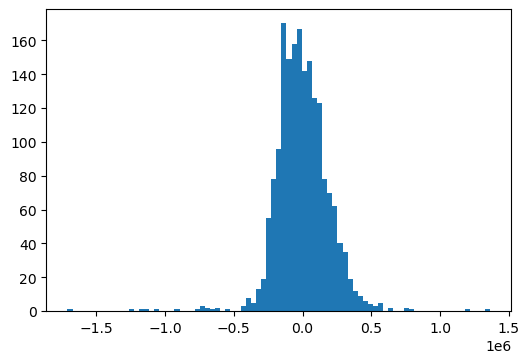

In [18]:
_ = plt.hist(results.resid, bins = "auto")

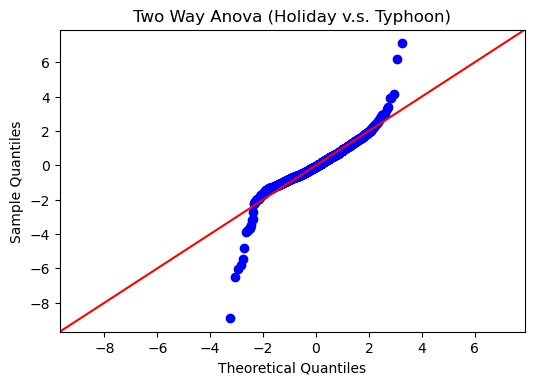

In [19]:
fig = sm.qqplot(results.resid, stats.norm, fit=True, line='45')
plt.title('Two Way Anova (Holiday v.s. Typhoon)')
plt.show()

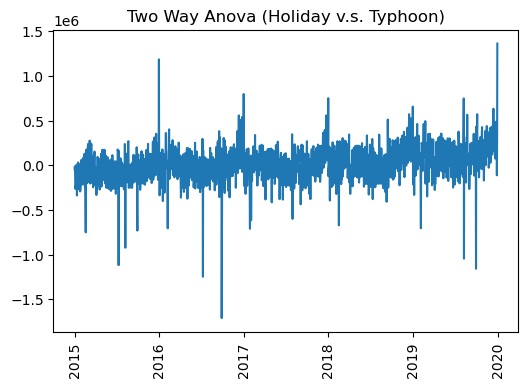

In [20]:
plt.plot(df0['Date'], results.resid)
plt.xticks(rotation = 90)
plt.title('Two Way Anova (Holiday v.s. Typhoon)')
plt.show()

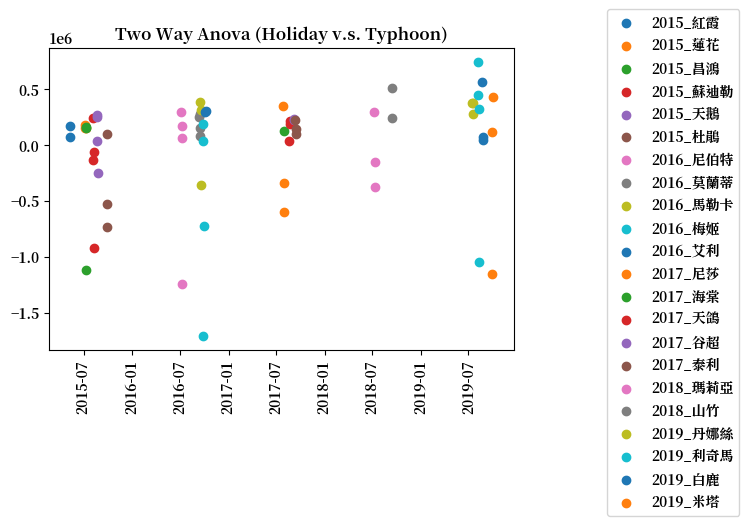

In [21]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
plt.rcParams['font.sans-serif'] = ['Noto Serif TC']

df0['resid'] = results.resid
typhoon = df0['Typhoon'] == True
t = df0[typhoon].reset_index(drop = True)
ls = t['Typhoon_Type']
b = {}
b = b.fromkeys(ls)
ls = list(b.keys())
# ls = list(set(t['Typhoon_Type']))
for l in ls:
    draw = t[t['Typhoon_Type'] == l]
    plt.scatter(draw['Date'], draw['resid'])

plt.legend(ls, loc ="upper right", bbox_to_anchor =(1.5, 1.15))
plt.xticks(rotation = 90)
plt.title('Two Way Anova (Holiday v.s. Typhoon)')
plt.show()

In [22]:
import statsmodels.stats.outliers_influence as sso
st1, data1, ss3 = sso.summary_table(results, alpha=0.05)
SD = data1[:, 10]
df1_c = pd.DataFrame([(SD), df0['Date']]).T
df1_c.columns = ['SD', 'Date']
filte = ((df1_c['SD'] < -4) | (df1_c['SD'] > 4))
print("Outliers by SD = \n")
display(df1_c[filte])

Outliers by SD = 



,SD,Date
190,-5.86185,2015-07-10
219,-5.85603,2015-08-08
364,6.19104,2015-12-31
554,-6.54285,2016-07-08
635,-8.96816,2016-09-27
730,4.16574,2016-12-31
1680,4.75262,2019-08-08
1681,-5.48103,2019-08-09
1733,-6.07426,2019-09-30
1825,7.11887,2019-12-31


In [23]:
a = df1_c[filte].reset_index()
outliers = [a['index'][i] for i in range(len(a))]
print(outliers)

[190, 219, 364, 554, 635, 730, 1680, 1681, 1733, 1825]


### Two Way Anova (節日、年份)

In [24]:
df1 = pd.DataFrame(list(transportCnt.items()), columns=['Date', 'TPcnt'])
df1['Holiday_Type'] = [holiday_type(day) for day in df1['Date']]
df1['Year'] = [day.year for day in df1['Date']]
df1 = df1.drop(df1[df1['Year'] >= 2020].index)
df1

,Date,TPcnt,Holiday_Type,Year
0,2015-01-01,1796950,National,2015
1,2015-01-02,1830184,National,2015
2,2015-01-03,1802037,National,2015
3,2015-01-04,1585463,National,2015
4,2015-01-05,1915326,Weekday,2015
...,...,...,...,...
1821,2019-12-27,2658619,Weekday,2019
1822,2019-12-28,2298630,Weekend,2019
1823,2019-12-29,1777124,Weekend,2019
1824,2019-12-30,2469682,Weekday,2019


In [25]:
results = smf.ols('TPcnt ~ C(Holiday_Type) + C(Year) + C(Holiday_Type):C(Year)', data=df1).fit()
# results.summary()
aov = sms.anova_lm(results, typ=2)
aov

,sum_sq,df,F,PR(>F)
C(Holiday_Type),5.692413e+13,5.0,324.997323,3.328007e-248
C(Year),8.572869e+12,4.0,61.181429,1.646902e-48
C(Holiday_Type):C(Year),1.984163e+12,20.0,2.832050,2.862246e-05
Residual,6.291481e+13,1796.0,NaN,NaN


In [26]:
stat, p = stats.shapiro(results.resid)
print('Statistics=%.4f, p=%.4f' % (stat, p))

Statistics=0.8480, p=0.0000


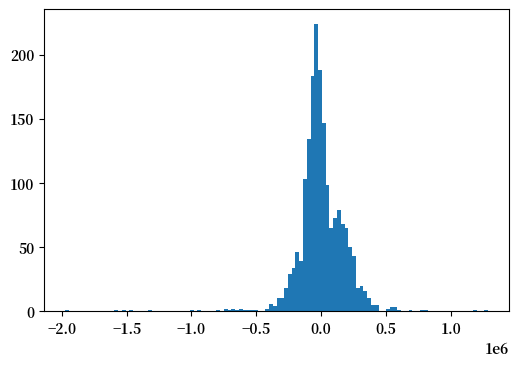

In [27]:
_ = plt.hist(results.resid, bins = "auto")

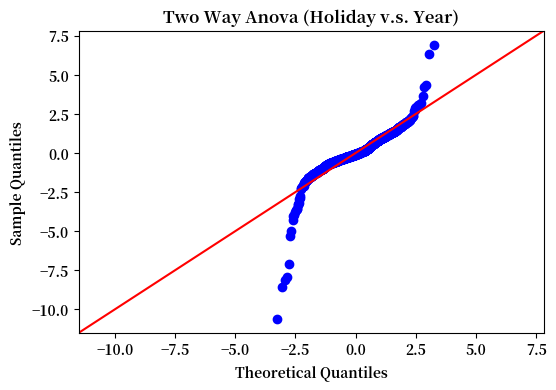

In [28]:
fig = sm.qqplot(results.resid, stats.norm, fit=True, line='45')
plt.title('Two Way Anova (Holiday v.s. Year)')
plt.show()

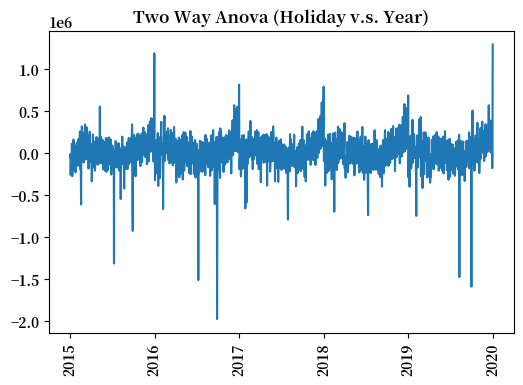

In [29]:
plt.plot(df1['Date'], results.resid)
plt.xticks(rotation = 90)
plt.title('Two Way Anova (Holiday v.s. Year)')
plt.show()

In [30]:
import statsmodels.stats.outliers_influence as sso
st1, data1, ss3 = sso.summary_table(results, alpha=0.05)
SD = data1[:, 10]
df1_c = pd.DataFrame([(SD), df1['Date']]).T
df1_c.columns = ['SD', 'Date']
filte = (df1_c['SD'] < -4) | (df1_c['SD'] > 4)
print("Outliers by SD = \n")
display(df1_c[filte])

Outliers by SD = 



,SD,Date
129,4.14035,2015-05-10
190,-7.03486,2015-07-10
219,-4.14035,2015-08-08
271,-4.96459,2015-09-29
364,6.49746,2015-12-31
554,-8.09067,2016-07-08
635,-10.5657,2016-09-27
636,-5.30394,2016-09-28
730,4.4707,2016-12-31
941,-4.25592,2017-07-30


In [31]:
a = df1_c[filte].reset_index()
outliers = [a['index'][i] for i in range(len(a))]
print(outliers)

[129, 190, 219, 271, 364, 554, 635, 636, 730, 941, 1095, 1495, 1681, 1733, 1825]


In [32]:
df1 = df1.drop(outliers)

### Two Way Anova (節日、季節)

In [33]:
df2 = pd.DataFrame(list(transportCnt.items()), columns=['Date', 'TPcnt'])
df2['Holiday_Type'] = [holiday_type(day) for day in df2['Date']]
df2['Year'] = [day.year for day in df2['Date']]
df2['Season'] = [season(day) for day in df2['Date']]
df2 = df2.drop(df2[df2['Year'] >= 2020].index)
df2

,Date,TPcnt,Holiday_Type,Year,Season
0,2015-01-01,1796950,National,2015,Winter
1,2015-01-02,1830184,National,2015,Winter
2,2015-01-03,1802037,National,2015,Winter
3,2015-01-04,1585463,National,2015,Winter
4,2015-01-05,1915326,Weekday,2015,Winter
...,...,...,...,...,...
1821,2019-12-27,2658619,Weekday,2019,Winter
1822,2019-12-28,2298630,Weekend,2019,Winter
1823,2019-12-29,1777124,Weekend,2019,Winter
1824,2019-12-30,2469682,Weekday,2019,Winter


In [34]:
results = smf.ols('TPcnt ~ C(Holiday_Type) + C(Season) + C(Holiday_Type):C(Season)', data=df2).fit()
# results.summary()
aov = sms.anova_lm(results, typ=2)
aov

D:\New folder\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 2
  warnings.warn('covariance of constraints does not have full '
D:\New folder\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
D:\New folder\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(Holiday_Type),9.162589e+13,5.0,479.934235,6.684488e-168
C(Season),7.434676e+10,3.0,0.649044,5.226667e-01
C(Holiday_Type):C(Season),3.382375e+12,15.0,5.905601,3.637744e-10
Residual,6.899612e+13,1807.0,NaN,NaN


In [35]:
stat, p = stats.shapiro(results.resid)
print('Statistics=%.4f, p=%.4f' % (stat, p))

Statistics=0.8800, p=0.0000


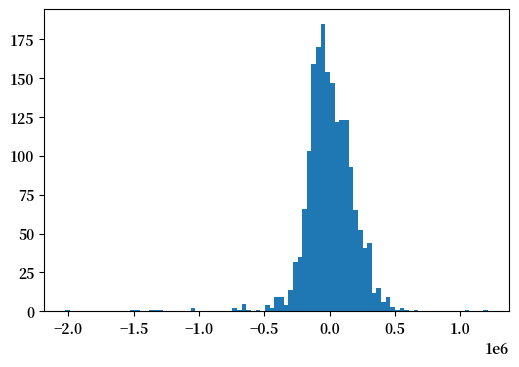

In [36]:
_ = plt.hist(results.resid, bins = "auto")

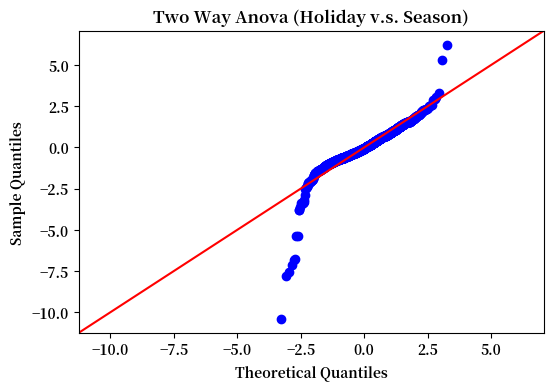

In [37]:
fig = sm.qqplot(results.resid, stats.norm, fit=True, line='45')
plt.title('Two Way Anova (Holiday v.s. Season)')
plt.show()

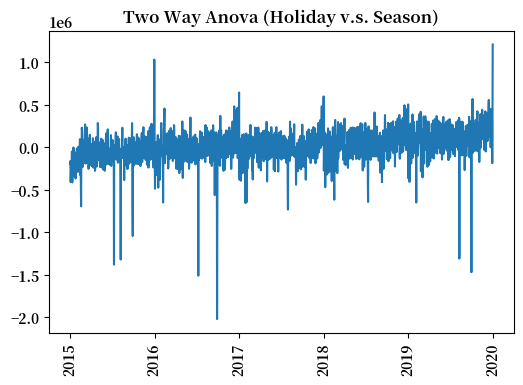

In [38]:
plt.plot(df2['Date'], results.resid)
plt.xticks(rotation = 90)
plt.title('Two Way Anova (Holiday v.s. Season)')
plt.show()


In [39]:
import statsmodels.stats.outliers_influence as sso
st1, data1, ss3 = sso.summary_table(results, alpha=0.05)
SD = data1[:, 10]
df1_c = pd.DataFrame([(SD), df2['Date']]).T
df1_c.columns = ['SD', 'Date']
filte = ((df1_c['SD'] < -4) | (df1_c['SD'] > 4))
print("Outliers by SD = \n")
display(df1_c[filte])

Outliers by SD = 



,SD,Date
190,-7.09124,2015-07-10
219,-7.56757,2015-08-08
271,-5.3571,2015-09-29
364,5.37987,2015-12-31
554,-7.75656,2016-07-08
635,-10.3743,2016-09-27
636,-5.33654,2016-09-28
1681,-6.71919,2019-08-09
1733,-7.54681,2019-09-30
1825,6.30497,2019-12-31


In [40]:
a = df1_c[filte].reset_index()
outliers = [a['index'][i] for i in range(len(a))]
print(outliers)

[190, 219, 271, 364, 554, 635, 636, 1681, 1733, 1825]


In [41]:
df2 = df2.drop(outliers)

## Two Way Anova (年份、季節)

In [42]:
df3 = pd.DataFrame(list(transportCnt.items()), columns=['Date', 'TPcnt'])
# df['Holiday_Type'] = [holiday_type(day) for day in df['Date']]
df3['Year'] = [day.year for day in df3['Date']]
df3['Season'] = [season(day) for day in df3['Date']]
df3 = df3.drop(df3[df3['Year'] >= 2020].index)
# df3 = df3.drop(columns = 'Date')
df3

,Date,TPcnt,Year,Season
0,2015-01-01,1796950,2015,Winter
1,2015-01-02,1830184,2015,Winter
2,2015-01-03,1802037,2015,Winter
3,2015-01-04,1585463,2015,Winter
4,2015-01-05,1915326,2015,Winter
...,...,...,...,...
1821,2019-12-27,2658619,2019,Winter
1822,2019-12-28,2298630,2019,Winter
1823,2019-12-29,1777124,2019,Winter
1824,2019-12-30,2469682,2019,Winter


In [43]:
results = smf.ols('TPcnt ~ C(Year) + C(Season) + C(Year):C(Season)', data=df3).fit()
# results.summary()
aov = sms.anova_lm(results, typ=2)
aov

,sum_sq,df,F,PR(>F)
C(Year),8.261937e+12,4.0,30.998831,5.367642e-25
C(Season),1.193969e+12,3.0,5.973038,4.755273e-04
C(Year):C(Season),2.934878e+11,12.0,0.367056,9.748162e-01
Residual,1.203356e+14,1806.0,NaN,NaN


In [44]:
stat, p = stats.shapiro(results.resid)
print('Statistics=%.4f, p=%.4f' % (stat, p))

Statistics=0.8681, p=0.0000


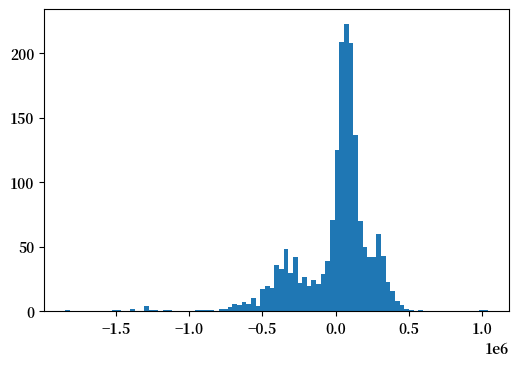

In [45]:
_ = plt.hist(results.resid, bins = "auto")

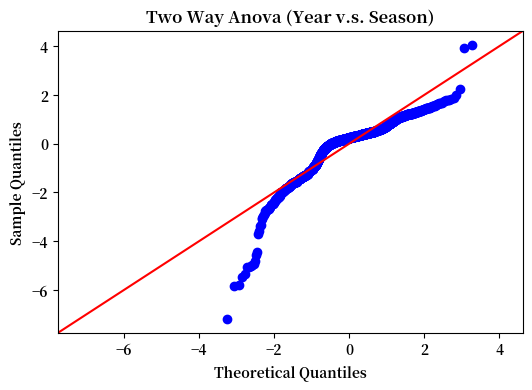

In [46]:
fig = sm.qqplot(results.resid, stats.norm, fit=True, line='45')
plt.title('Two Way Anova (Year v.s. Season)')
plt.show()

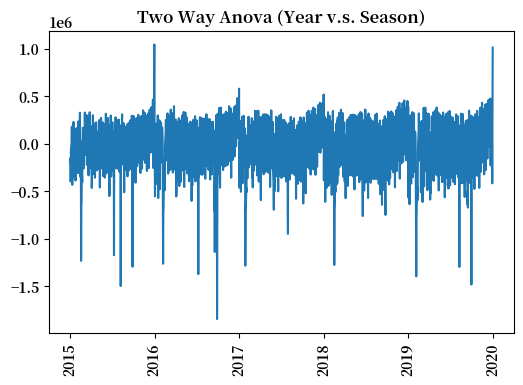

In [47]:
plt.plot(df3['Date'], results.resid)
plt.xticks(rotation = 90)
plt.title('Two Way Anova (Year v.s. Season)')
plt.show()
